In [23]:
#Libraries
import numpy as np
from scipy.integrate import odeint
from scipy.special import gamma
from scipy.constants import physical_constants as pc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
os.environ['PATH'] = os.environ['PATH'] + ':/plots_n/'
import matplotlib.colors as mcolors


plt.style.use(['classic',"seaborn-v0_8-dark"])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mcolors.TABLEAU_COLORS)
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 18
plt.rcParams["legend.frameon"]=True
plt.rcParams['lines.linewidth'] = 1.5

In [24]:
# Fundamental Constants
G_F = pc['Fermi coupling constant'][0]*1e-18 # eV^2 
N_A = pc['Avogadro constant'][0] # mol-1
hbar = pc['reduced Planck constant'][0]/pc['electron volt'][0] # eV.s
c = pc['speed of light in vacuum'][0] # m.s-1

# Flavour Specific Constants
del_m2_31=2.5*1e-3
del_m2_21=7.53*1e-5
theta_31=np.arcsin(np.sqrt(2.18*1e-2))
theta_21=np.arcsin(np.sqrt(0.307))

# Conversion Factors
eV_to_1_by_m = pc['electron volt-inverse meter relationship'][0]
eV_to_1_by_km = eV_to_1_by_m*1e3
one_by_cm3_to_eV3 = (1.973*1e-5)**3
erg_to_MeV = 6.2415*1e5

In [25]:
# Matter Potential
def A_cc(n_e, E):
    return 2*np.sqrt(2)*G_F*n_e*E

# Effective mass squared difference in matter
def del_m2_eff(del_m2, theta, A_cc):
    x = np.sqrt((del_m2*np.cos(2*theta) - A_cc)**2 + (del_m2*np.sin(2*theta))** 2)
    return x

# Effective mixing angle
def theta_eff(del_m2, theta, A_cc):
    num = del_m2*np.sin(2*theta)
    den = del_m2*np.cos(2*theta) - A_cc
    return 0.5*np.arctan2(num,den)

# L vector
def L_vec(n_dim):
    if n_dim ==3:
        return np.array([0,0,1])
    raise ValueError("Dimension not defined")

# B vector
def B_vec(n_dim, theta):
    if n_dim == 3:
        return np.array([-np.sin(2*theta), 0, np.cos(2*theta)])
    raise ValueError("Dimension not defined")

In [26]:
# Neutrino-Neutrino Potential
def mu_r(r, opt, mu0=0):
    if opt == "SN":
        R0 = 40 # km
        if r < R0:
            return mu0
        else:
            return mu0*(R0/r)**4 #eV
    
    elif opt == "const":
        return mu0
    
    else:
        return ValueError("Invalid option chosen")
    
mu_vec = np.vectorize(mu_r)

In [27]:
# Matter Density Profile
def SN_density_profile(r, t):
    """
    Reference: https://arxiv.org/abs/hep-ph/0304056
    """
    r = np.array(r)
    rho0 = 1e14*r**(-2.4)  # g/cm³

    if t < 1:
        return rho0

    # Shockwave parameters
    epsilon = 10
    r_s0 = -4.6e3     # km
    v_s = 11.3e3      # km/s
    a_s = 0.2e3       # km/s²
    r_s = r_s0 + v_s* t + 0.5*a_s*t**2  # Shockwave position

    # Apply shockwave-modified profile where r <= r_s
    rho = rho0.copy()
    mask = r <= r_s
    with np.errstate(invalid='ignore'):
        a = (0.28 - 0.69*np.log(r[mask]))*(np.arcsin(1 - r[mask]/r_s)**1.1)
        rho[mask] *= epsilon*np.exp(a)

    return rho

In [28]:
# Electron density profile
def lambda_sn(r, option, n=N_A, t=1.0):
    m_n = pc['neutron mass'][0]*1e3 # g
    Y_e = 0.5  # electron fraction

    if option == "no":
        n_eff = 0
    elif option == "const":
        n_eff = n
    elif option == "SN":
        n_eff = (Y_e/m_n)*SN_density_profile(r, t)  # electrons per cm³
    else:
        raise ValueError("Invalid option for matter density profile. Choose 'no', 'const', or 'SN'.")

    return np.sqrt(2)*G_F*n_eff*one_by_cm3_to_eV3

In [29]:
def MultiAngle_mono(y, r, params):
    omega, opt, mu0, l_option, l0, n_dim, N_u, R = params

    # Unpack and reshape polarization vectors
    y = y.reshape(2, N_u, n_dim)
    P_nu = y[0]
    P_anu = y[1]

    B = np.array(B_vec(n_dim, theta_31))
    L = np.array(L_vec(n_dim))

    r_phys = r / eV_to_1_by_km
    mu = mu_r(r_phys, opt, mu0)
    lamb = lambda_sn(r_phys, l_option, l0)

    u_vals = np.linspace(0, 1, N_u)
    v_u = np.sqrt(1 - u_vals * R**2 / r_phys**2)  # shape: (N_u,)

    # Compute angle-averaged P, Pbar
    P_avg = np.trapz(P_nu / v_u[:, np.newaxis], u_vals, axis=0)
    Pbar_avg = np.trapz(P_anu / v_u[:, np.newaxis], u_vals, axis=0)

    dP_nu = np.zeros_like(P_nu)
    dP_anu = np.zeros_like(P_anu)

    for i, (u, v) in enumerate(zip(u_vals, v_u)):
        P_i = P_nu[i]
        Pbar_i = P_anu[i]

        H_nu = omega * B + lamb * L
        H_anu = -omega * B + lamb * L

        # Interaction integral
        integrand = (P_nu - P_anu) / v_u[:, np.newaxis]
        int_term = np.trapz(integrand, u_vals, axis=0)

        # Full Hamiltonians
        H_nu += mu * (R**2 / r_phys**2) * np.cross(int_term, (P_i / v) - np.cross(P_avg - Pbar_avg, P_i))
        H_anu -= mu * (R**2 / r_phys**2) * np.cross(int_term, (Pbar_i / v) - np.cross(P_avg - Pbar_avg, Pbar_i))

        dP_nu[i] = np.cross(P_i, H_nu) / v
        dP_anu[i] = np.cross(Pbar_i, H_anu) / v

    dy = np.concatenate([dP_nu, dP_anu]).flatten()
    return dy


In [30]:
def MA_solver(P0, E, r_i, r_f, mass_ord, opt, mu0, l_opt="no", l0=0, n_f=2, N_u=100, R=10):
    n_dim = n_f**2 - 1
    omega = del_m2_31 / (2 * E * 1e6)  # MeV to eV

    if mass_ord == "IH":
        omega *= -1

    r_i *= eV_to_1_by_km
    r_f *= eV_to_1_by_km
    r_step = 2 * np.pi / (max(omega, mu0) * 200)
    r = np.arange(r_i, r_f, r_step)

    # Initial state: shape (2, N_u, n_dim)
    y0 = np.tile(P0, (2, N_u, 1))  # [P_nu, P_anu]
    y0 = y0.flatten()

    params = (omega, opt, mu0, l_opt, l0, n_dim, N_u, R)
    sol = odeint(MultiAngle_mono, y0, r, args=(params,))
    sol = sol.reshape(-1, 2, N_u, n_dim)

    r = r / eV_to_1_by_km  # Convert back to km
    return sol, r


In [31]:
def Plot_Probability_MultiAngle(sol_NH, sol_IH, r, E, omega, mu0):
    # Extract z-components (ν_e and ν̄_e survival probabilities)
    Pz_nu_NH = sol_NH[:, 0, :, 2]    # shape: (len(r), N_u)
    Pz_nu_IH = sol_IH[:, 0, :, 2]
    Pz_anu_NH = sol_NH[:, 1, :, 2]
    Pz_anu_IH = sol_IH[:, 1, :, 2]

    # Angle averages
    Pz_nu_avg_NH = np.mean(Pz_nu_NH, axis=1)
    Pz_nu_avg_IH = np.mean(Pz_nu_IH, axis=1)
    Pz_anu_avg_NH = np.mean(Pz_anu_NH, axis=1)
    Pz_anu_avg_IH = np.mean(Pz_anu_IH, axis=1)

    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Neutrinos
    ax.plot(r, 0.5 * (1 + Pz_nu_avg_NH / Pz_nu_avg_NH[0]), label=r'$\nu_e$ NH')
    ax.plot(r, 0.5 * (1 + Pz_nu_avg_IH / Pz_nu_avg_NH[0]), '--', label=r'$\nu_e$ IH')

    # Antineutrinos
    ax.plot(r, 0.5 * (1 + Pz_anu_avg_NH / Pz_anu_avg_NH[0]), label=r'$\overline{\nu}_e$ NH')
    ax.plot(r, 0.5 * (1 + Pz_anu_avg_IH / Pz_anu_avg_NH[0]), '--', label=r'$\overline{\nu}_e$ IH')

    ax.set_ylabel(r'Survival Probability')
    ax.set_xlabel('r [km]')
    ax.set_title(r'$E_{\nu}=%1.f$ MeV, $\omega=%.1e$ eV, $\mu_0=%.1e$ eV' % (E, omega, mu0))
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [32]:
P = [0, 0, 1]  # initial polarization direction for each angle
E = 20  # MeV
r_i, r_f = 0.1, 40  # km
omega = del_m2_31 / (2 * E * 1e6)  # in eV
omega_max = del_m2_31 / (2 * 1e6)  # E = 1 MeV
opt, mu0 = "const", 10 * omega_max

# Multi-angle parameters
N_u = 100
R = 10  # km

# Initial condition array for all angle bins
P0 = np.array(P)

# Solve for IH
sol_IH, r_IH = MA_solver(P0, E, r_i, r_f, "IH", opt, mu0, l_opt="no", l0=0, n_f=2, N_u=N_u, R=R)

# Solve for NH
sol_NH, r_NH = MA_solver(P0, E, r_i, r_f, "NH", opt, mu0, l_opt="no", l0=0, n_f=2, N_u=N_u, R=R)


/tmp/ipykernel_3894/3517603172.py:17: RuntimeWarning: invalid value encountered in sqrt
  v_u = np.sqrt(1 - u_vals * R**2 / r_phys**2)  # shape: (N_u,)
/tmp/ipykernel_3894/464126789.py:18: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(MultiAngle_mono, y0, r, args=(params,))


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8316871349287D+08   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8316871349287D+08   r2 =                  NaN


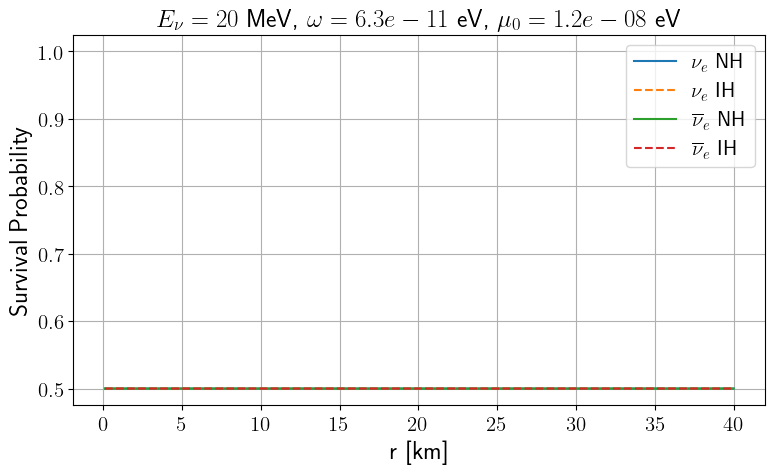

In [33]:
Plot_Probability_MultiAngle(sol_NH, sol_IH, r_NH, E, omega, mu0)
